## Code for the experiments - training with Adam and no dropout
### Importing and preparing data
First we import the relevant packages. 

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical

Using TensorFlow backend.


Importing the dataset MNIST_fashion. It is an MNIST-like dataset, but contains images of clothing instead of numbers. The image size is the same as in MNIST. 

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Scaling the pixels to values between 0 and 1. 

In [4]:
train_images = train_images / 255.0
test_images = test_images / 255.0

The labels are given in integer values between 0 and 9. For the Self-Distillation we convert these into the one-hot representation, for example a trouser with label [1] now has label [0,1,0,0,0,0,0,0,0,0] with 1 at the first entry (note that counting starts with 0 here). 

In [5]:
train_labels_onehot = to_categorical(train_labels)
test_labels_onehot = to_categorical(test_labels)

Reshaping the data so that it fits into the functions later. 

In [6]:
im_rows=28
im_cols=28
im_shape=(im_rows,im_cols,1)

train_images = train_images.reshape(train_images.shape[0],*im_shape)
test_images = test_images.reshape(test_images.shape[0],*im_shape)

### Defining the models
Defining all the models that will be used later, so that we can see a summary. Note that the each model will be re-initialized later in each for-step, since each Self-Distillation step requires a fresh model that hasn't been trained yet. 

In [7]:
name = 'Convolutional_2_Layer'
cnn_model_2 = keras.Sequential([
    keras.layers.Conv2D(filters=32,kernel_size=3,input_shape=im_shape),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(filters = 64, kernel_size = 3, activation ='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation ='softmax')], name = name)

name = 'Convolutional_4_Layer_CE'
cnn_model_4 = keras.Sequential([
    keras.layers.Conv2D(filters=32,kernel_size=3,input_shape=im_shape),
    keras.layers.Conv2D(filters=32,kernel_size=3,input_shape=im_shape),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(filters = 64, kernel_size = 3, activation ='relu'),
    keras.layers.Conv2D(filters = 128, kernel_size =3, activation ='relu'),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(10)], name = name)

name = 'Feedforward_2_Layer'
ff_model_2 = keras.Sequential([
    keras.layers.Flatten(input_shape=im_shape),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(10, activation ='softmax')], name = name)


models = [cnn_model_2, cnn_model_4, ff_model_2]

In [8]:
for model in models:
    model.summary()

Model: "Convolutional_2_Layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 7744)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                495680    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 515,146
Trainable params: 515,146
Non-trainable params: 0
_______________________________________

### Training the CNN's with cross-entropy loss
##### Training the 2-layer CNN with cross-entropy loss

In [9]:
train_labels_Iterations_2layerCE = np.zeros((60000,10,5),dtype='float32')
label_update_2layerCE = train_labels_onehot
predictions_2layerCE = np.zeros((10000,10,5),dtype='float32')
test_loss_2CNNCE = np.zeros(5,dtype='float32')
test_acc_2CNNCE = np.zeros(5,dtype='float32')
for i in range(5):
    print('ROUND',i+1)
    
    name = 'Convolutional_2_Layer_CE'
    cnn_model_2CE = keras.Sequential([
    keras.layers.Conv2D(filters=32,kernel_size=3,input_shape=im_shape),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(filters = 64, kernel_size = 3, activation ='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10)], name = name)
    
    cnn_model_2CE.compile(optimizer='Adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    cnn_model_2CE.fit(train_images, label_update_2layerCE, epochs=10)
    probability_cnn_model_2CE = tf.keras.Sequential([cnn_model_2CE, 
                                         tf.keras.layers.Softmax()])
    test_loss_2CNNCE[i], test_acc_2CNNCE[i] = cnn_model_2CE.evaluate(test_images,  test_labels_onehot, verbose=2)
    print('\nTest accuracy:', test_acc_2CNNCE[i])
    label_update_2layerCE = probability_cnn_model_2CE.predict(train_images)
    predictions_2layerCE[:,:,i] = probability_cnn_model_2CE.predict(test_images)

ROUND 1
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 14s 233us/sample - loss: 0.4025 - accuracy: 0.8542
Epoch 2/10
60000/60000 [==============================] - 11s 191us/sample - loss: 0.2672 - accuracy: 0.9017
Epoch 3/10
60000/60000 [==============================] - 11s 192us/sample - loss: 0.2209 - accuracy: 0.9189
Epoch 4/10
60000/60000 [==============================] - 11s 190us/sample - loss: 0.1872 - accuracy: 0.9298
Epoch 5/10
60000/60000 [==============================] - 11s 191us/sample - loss: 0.1567 - accuracy: 0.9414
Epoch 6/10
60000/60000 [==============================] - 11s 191us/sample - loss: 0.1328 - accuracy: 0.9504
Epoch 7/10
60000/60000 [==============================] - 11s 191us/sample - loss: 0.1127 - accuracy: 0.9580
Epoch 8/10
60000/60000 [==============================] - 11s 190us/sample - loss: 0.0936 - accuracy: 0.9654
Epoch 9/10
60000/60000 [==============================] - 11s 191us/sample - loss: 0.0791 - accur

##### Training the 4layer convoluiontal NN with cross-entropy loss

In [10]:
train_labels_Iterations_4layerCE = np.zeros((60000,10,5),dtype='float32')
label_update_4layerCE = train_labels_onehot
predictions_4layerCE = np.zeros((10000,10,5),dtype='float32')
test_loss_4CNNCE = np.zeros(5,dtype='float32')
test_acc_4CNNCE = np.zeros(5,dtype='float32')
for i in range(5):
    print('ROUND',i+1)
    
    name = 'Convolutional_4_Layer_CE'
    cnn_model_4CE = keras.Sequential([
    keras.layers.Conv2D(filters=32,kernel_size=3,input_shape=im_shape),
    keras.layers.Conv2D(filters=32,kernel_size=3,input_shape=im_shape),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(filters = 64, kernel_size = 3, activation ='relu'),
    keras.layers.Conv2D(filters = 128, kernel_size =3, activation ='relu'),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(10)], name = name)
    
    cnn_model_4CE.compile(optimizer='Adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    cnn_model_4CE.fit(train_images, label_update_4layerCE, epochs=10)
    probability_cnn_model_4CE = tf.keras.Sequential([cnn_model_4CE, 
                                         tf.keras.layers.Softmax()])
    test_loss_4CNNCE[i], test_acc_4CNNCE[i] = cnn_model_4CE.evaluate(test_images,  test_labels_onehot, verbose=2)
    print('\nTest accuracy:', test_acc_4CNNCE[i])
    label_update_4layerCE = probability_cnn_model_4CE.predict(train_images)
    predictions_4layerCE[:,:,i] = probability_cnn_model_4CE.predict(test_images)

ROUND 1
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 31s 508us/sample - loss: 0.4417 - accuracy: 0.8367
Epoch 2/10
60000/60000 [==============================] - 29s 478us/sample - loss: 0.2898 - accuracy: 0.8932
Epoch 3/10
60000/60000 [==============================] - 28s 472us/sample - loss: 0.2391 - accuracy: 0.9117
Epoch 4/10
60000/60000 [==============================] - 28s 472us/sample - loss: 0.2041 - accuracy: 0.9246
Epoch 5/10
60000/60000 [==============================] - 28s 472us/sample - loss: 0.1720 - accuracy: 0.9363
Epoch 6/10
60000/60000 [==============================] - 28s 472us/sample - loss: 0.1498 - accuracy: 0.9441
Epoch 7/10
60000/60000 [==============================] - 28s 472us/sample - loss: 0.1307 - accuracy: 0.9510
Epoch 8/10
60000/60000 [==============================] - 28s 474us/sample - loss: 0.1162 - accuracy: 0.9569
Epoch 9/10
60000/60000 [==============================] - 29s 476us/sample - loss: 0.1029 - accur

### Training the CNN's with mean-squared-error loss
##### Training the 2-layer CNN mean-squared-error loss

In [11]:
train_labels_Iterations_2layerMSE = np.zeros((60000,10,5),dtype='float32')
label_update_2layerMSE = train_labels_onehot
predictions_2layerMSE = np.zeros((10000,10,5),dtype='float32')
test_loss_2CNNMSE = np.zeros(5,dtype='float32')
test_acc_2CNNMSE = np.zeros(5,dtype='float32')
for i in range(5):
    print('ROUND',i+1)
    
    name = 'Convolutional_2_Layer_MSE'
    cnn_model_2MSE = keras.Sequential([
    keras.layers.Conv2D(filters=32,kernel_size=3,input_shape=im_shape),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(filters = 64, kernel_size = 3, activation ='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10)], name = name)
    
    cnn_model_2MSE.compile(optimizer='Adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])
    
    cnn_model_2MSE.fit(train_images, label_update_2layerMSE, epochs=10)
    probability_cnn_model_2MSE = tf.keras.Sequential([cnn_model_2MSE, 
                                         tf.keras.layers.Softmax()])
    test_loss_2CNNMSE[i], test_acc_2CNNMSE[i] = cnn_model_2MSE.evaluate(test_images,  test_labels_onehot, verbose=2)
    print('\nTest accuracy:', test_acc_2CNNMSE[i])
    label_update_2layerMSE = probability_cnn_model_2MSE.predict(train_images)
    predictions_2layerMSE[:,:,i] = probability_cnn_model_2MSE.predict(test_images)

ROUND 1
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 11s 189us/sample - loss: 0.0234 - accuracy: 0.8661
Epoch 2/10
60000/60000 [==============================] - 12s 198us/sample - loss: 0.0163 - accuracy: 0.9087
Epoch 3/10
60000/60000 [==============================] - 11s 186us/sample - loss: 0.0141 - accuracy: 0.9233
Epoch 4/10
60000/60000 [==============================] - 11s 187us/sample - loss: 0.0126 - accuracy: 0.9348
Epoch 5/10
60000/60000 [==============================] - 11s 185us/sample - loss: 0.0114 - accuracy: 0.9433
Epoch 6/10
60000/60000 [==============================] - 11s 182us/sample - loss: 0.0103 - accuracy: 0.9513
Epoch 7/10
60000/60000 [==============================] - 11s 183us/sample - loss: 0.0095 - accuracy: 0.9569
Epoch 8/10
60000/60000 [==============================] - 11s 187us/sample - loss: 0.0087 - accuracy: 0.9630
Epoch 9/10
60000/60000 [==============================] - 11s 181us/sample - loss: 0.0081 - accur

##### Training the 4layer convoluiontal NN with mean-squared-error loss

In [12]:
train_labels_Iterations_4layerMSE = np.zeros((60000,10,5),dtype='float32')
label_update_4layerMSE = train_labels_onehot
predictions_4layerMSE = np.zeros((10000,10,5),dtype='float32')
test_loss_4CNNMSE = np.zeros(5,dtype='float32')
test_acc_4CNNMSE = np.zeros(5,dtype='float32')
for i in range(5):
    print('ROUND',i+1)
    
    name = 'Convolutional_4_Layer_MSE'
    cnn_model_4MSE = keras.Sequential([
    keras.layers.Conv2D(filters=32,kernel_size=3,input_shape=im_shape),
    keras.layers.Conv2D(filters=32,kernel_size=3,input_shape=im_shape),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(filters = 64, kernel_size = 3, activation ='relu'),
    keras.layers.Conv2D(filters = 128, kernel_size =3, activation ='relu'),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(10)], name = name)
    
    cnn_model_4MSE.compile(optimizer='Adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])
    
    cnn_model_4MSE.fit(train_images, label_update_4layerMSE, epochs=10)
    probability_cnn_model_4MSE = tf.keras.Sequential([cnn_model_4MSE, 
                                         tf.keras.layers.Softmax()])
    test_loss_4CNNMSE[i], test_acc_4CNNMSE[i] = cnn_model_4MSE.evaluate(test_images,  test_labels_onehot, verbose=2)
    print('\nTest accuracy:', test_acc_4CNNMSE[i])
    label_update_4layerMSE = probability_cnn_model_4MSE.predict(train_images)
    predictions_4layerMSE[:,:,i] = probability_cnn_model_4MSE.predict(test_images)

ROUND 1
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 28s 471us/sample - loss: 0.0222 - accuracy: 0.8587
Epoch 2/10
60000/60000 [==============================] - 28s 465us/sample - loss: 0.0149 - accuracy: 0.9042
Epoch 3/10
60000/60000 [==============================] - 28s 465us/sample - loss: 0.0125 - accuracy: 0.9205
Epoch 4/10
60000/60000 [==============================] - 28s 464us/sample - loss: 0.0109 - accuracy: 0.9312
Epoch 5/10
60000/60000 [==============================] - 28s 463us/sample - loss: 0.0093 - accuracy: 0.9420
Epoch 6/10
60000/60000 [==============================] - 28s 463us/sample - loss: 0.0081 - accuracy: 0.9512
Epoch 7/10
60000/60000 [==============================] - 28s 465us/sample - loss: 0.0071 - accuracy: 0.9590
Epoch 8/10
60000/60000 [==============================] - 28s 463us/sample - loss: 0.0061 - accuracy: 0.9648
Epoch 9/10
60000/60000 [==============================] - 28s 463us/sample - loss: 0.0055 - accur

### Training the feed-forward NN with cross-entropy loss and mean-squared-error loss
###### Training the 2-layer feed-forward NN with cross-entropy loss

In [13]:
train_labels_Iterations_2layerFF_CE = np.zeros((60000,10,5),dtype='float32')
label_update_2layerFF_CE = train_labels_onehot
predictions_2layerFF_CE = np.zeros((10000,10,5),dtype='float32')
test_loss_2FFCE = np.zeros(5,dtype='float32')
test_acc_2FFCE = np.zeros(5,dtype='float32')
for i in range(5):
    print('ROUND',i+1)
    
    name = 'Feedforward_2_Layer_CE'
    ff_model_2CE = keras.Sequential([
    keras.layers.Flatten(input_shape=im_shape),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(10, activation ='softmax')], name = name)
    
    ff_model_2CE.compile(optimizer='Adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    ff_model_2CE.fit(train_images, label_update_2layerFF_CE, epochs=10)
    probability_ff_model_2CE = tf.keras.Sequential([ff_model_2CE, 
                                         tf.keras.layers.Softmax()])
    test_loss_2FFCE[i], test_acc_2FFCE[i] = ff_model_2CE.evaluate(test_images,  test_labels_onehot, verbose=2)
    print('\nTest accuracy:', test_acc_2FFCE[i])
    label_update_2layerFF_CE = probability_ff_model_2CE.predict(train_images)
    predictions_2layerFF_CE[:,:,i] = probability_ff_model_2CE.predict(test_images)

ROUND 1
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 72us/sample - loss: 1.6702 - accuracy: 0.7959
Epoch 2/10
60000/60000 [==============================] - 4s 67us/sample - loss: 1.6238 - accuracy: 0.8371
Epoch 3/10
60000/60000 [==============================] - 4s 67us/sample - loss: 1.6124 - accuracy: 0.8489
Epoch 4/10
60000/60000 [==============================] - 4s 67us/sample - loss: 1.6076 - accuracy: 0.8532
Epoch 5/10
60000/60000 [==============================] - 4s 67us/sample - loss: 1.6007 - accuracy: 0.8599
Epoch 6/10
60000/60000 [==============================] - 4s 67us/sample - loss: 1.5974 - accuracy: 0.8633
Epoch 7/10
60000/60000 [==============================] - 4s 67us/sample - loss: 1.5935 - accuracy: 0.8672
Epoch 8/10
60000/60000 [==============================] - 4s 68us/sample - loss: 1.5921 - accuracy: 0.8687
Epoch 9/10
60000/60000 [==============================] - 4s 67us/sample - loss: 1.5908 - accuracy: 0.8698
Epoch 

###### Training the 2-layer feed-forward NN with mean-squared-error loss

In [14]:
train_labels_Iterations_2layerFF_MSE = np.zeros((60000,10,5),dtype='float32')
label_update_2layerFF_MSE = train_labels_onehot
predictions_2layerFF_MSE = np.zeros((10000,10,5),dtype='float32')
test_loss_2FFMSE = np.zeros(5,dtype='float32')
test_acc_2FFMSE = np.zeros(5,dtype='float32')
for i in range(5):
    print('ROUND',i+1)
    
    name = 'Feedforward_2_Layer_MSE'
    ff_model_2MSE = keras.Sequential([
    keras.layers.Flatten(input_shape=im_shape),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(10, activation ='softmax')], name = name)
    
    ff_model_2MSE.compile(optimizer='Adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])
    
    ff_model_2MSE.fit(train_images, label_update_2layerFF_MSE, epochs=10)
    probability_ff_model_2MSE = tf.keras.Sequential([ff_model_2MSE, 
                                         tf.keras.layers.Softmax()])
    test_loss_2FFMSE[i], test_acc_2FFMSE[i] = ff_model_2MSE.evaluate(test_images,  test_labels_onehot, verbose=2)
    print('\nTest accuracy:', test_acc_2FFMSE[i])
    label_update_2layerFF_MSE = probability_ff_model_2MSE.predict(train_images)
    predictions_2layerFF_MSE[:,:,i] = probability_ff_model_2MSE.predict(test_images)

ROUND 1
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 66us/sample - loss: 0.0254 - accuracy: 0.8235
Epoch 2/10
60000/60000 [==============================] - 4s 60us/sample - loss: 0.0198 - accuracy: 0.8632
Epoch 3/10
60000/60000 [==============================] - 4s 60us/sample - loss: 0.0181 - accuracy: 0.8750
Epoch 4/10
60000/60000 [==============================] - 4s 60us/sample - loss: 0.0170 - accuracy: 0.8832
Epoch 5/10
60000/60000 [==============================] - 4s 61us/sample - loss: 0.0161 - accuracy: 0.8893
Epoch 6/10
60000/60000 [==============================] - 4s 60us/sample - loss: 0.0156 - accuracy: 0.8929
Epoch 7/10
60000/60000 [==============================] - 4s 61us/sample - loss: 0.0150 - accuracy: 0.8972
Epoch 8/10
60000/60000 [==============================] - 4s 60us/sample - loss: 0.0145 - accuracy: 0.9010
Epoch 9/10
60000/60000 [==============================] - 4s 60us/sample - loss: 0.0141 - accuracy: 0.9034
Epoch 

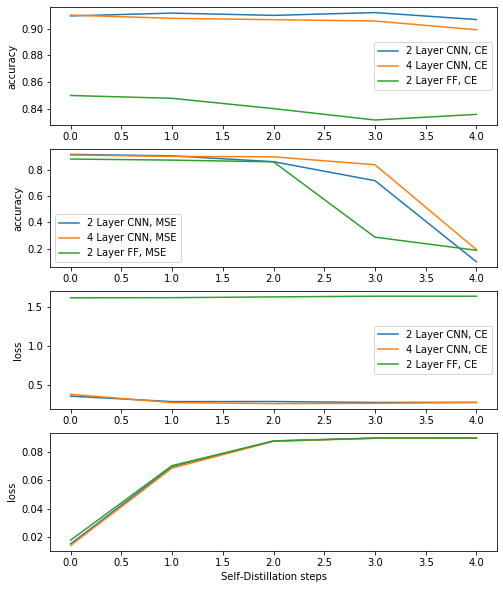

In [18]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(8, 10))

ax1.plot(test_acc_2CNNCE,label='2 Layer CNN, CE')
ax2.plot(test_acc_2CNNMSE,label='2 Layer CNN, MSE')
ax1.plot(test_acc_4CNNCE,label='4 Layer CNN, CE')
ax2.plot(test_acc_4CNNMSE,label='4 Layer CNN, MSE')
ax1.plot(test_acc_2FFCE,label='2 Layer FF, CE')
ax2.plot(test_acc_2FFMSE,label='2 Layer FF, MSE')

ax3.plot(test_loss_2CNNCE,label='2 Layer CNN, CE')
ax4.plot(test_loss_2CNNMSE,label='2 Layer CNN, MSE')
ax3.plot(test_loss_4CNNCE,label='4 Layer CNN, CE')
ax4.plot(test_loss_4CNNMSE,label='4 Layer CNN, MSE')
ax3.plot(test_loss_2FFCE,label='2 Layer FF, CE')
ax4.plot(test_loss_2FFMSE,label='2 Layer FF, MSE')

ax1.set_ylabel('accuracy')
ax2.set_ylabel('accuracy')
ax3.set_ylabel('loss')
ax4.set_ylabel('loss')
ax4.set_xlabel('Self-Distillation steps')
ax1.legend()
ax2.legend()
ax3.legend()
ax3.legend()
plt.savefig('Adam-NODropout-figure')
plt.show()